# Esempio Prova Esonero - Metodi AI e Machine Learning per la fisica 

In [ ]:
 !rm -rf MS_vertex_esonero.npz
 !wget http://giagu.web.cern.ch/giagu/CERN/MS_vertex_esonero.npz 

--2023-04-02 15:44:49--  http://giagu.web.cern.ch/giagu/CERN/MS_vertex_esonero.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106576990 (102M)
Saving to: ‘MS_vertex_esonero.npz’

MS_vertex_esonero.n 100%[===================>] 101.64M  3.48MB/s    in 56s     

2023-04-02 15:45:46 (1.83 MB/s) - ‘MS_vertex_esonero.npz’ saved [106576990/106576990]



# Descrizione del compito:

### Dataset:

il dataset fornito è costituito da un file in formato numpy binario *.npz*: *MS_vertex_esonero.npz*, che contiene due tensory numpy (data e target) con shape:
*   data (1000,20,333)
*   target (1000,)

il tensore data contiene per 1000 esempi un'immagine binaria (valore dei pixel {0,1}) che rappresenta il segnale misurato in un rivelatore di particelle cariche in un esperimento di alta energia. I segnali sono prodotti dalle particelle (10 per ogni evento) che provengono dal decadimento di una particella madre che decade a distanze diverse dal rivelatore. Il target rappresenta la distanza di decadimento $d_0$ (in metri) della particella madre dal vertice di interazione posto nell'origine del sistema di coordinate dell'esperimento (il rivelatore si trova a 5m di distanza dall'origine, la distanza $d_0$ può assumere valori continui tra 0m (decadimento nel vertice di interazione alla massima distanza dal rivelatore) e 4.9m (decadimento molto vicino al vertice di interazione).

E' possibile leggere i tensori usando il seguente esempio di codice:

```
inp_file = np.load('MS_vertex_esonero.npz')
data = inp_file['data']
target = inp_file['target']

print(data.shape)
print(target.shape)
```


**È richiesto:**
  
1.   di associare una opportuna label agli eventi del campione che li divida in eventi "prompt" e eventi "displaced", basandosi sul valore del target:
> prompt: $d_0 <= 1.5$ m <p>
> displaced: $d_0 > 1.5$ m <p>
2.   di allenare un modello di regressione basato su una architettura RandomForest che predica il valore della distanza di decadimento $\hat{d}_0$ a partire da una delle immagini del campione
3.   valutarne le prestazioni in termini di metriche standard per task di regressione, che calcolando la risoluzione media su $d_0$ ($<d_0-\hat{d}_0>$) per le due classi di eventi prompt e displaced. 
4.  allenare un modello di classificazione basato su un classificatore a k-primi vicini che assegni un particolare evento ad una tra le due possibili categorie prompt o displaced, valutandone opportunamente le prestazioni

Commentare in modo sintetico le scelte e operazioni eseguite nello svolgimento dei vari punti del compito.

In [ ]:
# codice ...
#Importo file e costruisco array
import numpy as np
inp_file = np.load('MS_vertex_esonero.npz')
data = inp_file['data']
target = inp_file['target']

print("Shape data : {}".format(data.shape))
print("Shape target: {}".format(target.shape))

Shape data : (1000, 20, 333)
Shape target: (1000,)


In [ ]:
type(target)

numpy.ndarray

In [ ]:
#PUNTO 1
#Costruisco array di label a partire da quello di target
prompt = target <= 1.5
displaced = target > 1.5

label = np.zeros(len(target))
label[prompt] = 0
label[displaced] = 1

print("shape e lunghezza del nuovo array di label: {} \t {}".format(label.shape, len(label)))

shape e lunghezza del nuovo array di label: (1000,) 	 1000


In [ ]:
#PUNTO 2
#Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Devo reshapare l'array data in modo che sia al massimo bidimensionale (avrò 1000 eventi ciascuno composto da 20*333 features)
data = np.reshape(data, (1000, 20*333))

#splitto il campione in training and testing
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, train_size = 0.6)
#Splitto test set in validation and test sets
x_vali, x_test, y_vali, y_test = train_test_split(x_test, y_test, test_size = 0.5, train_size = 0.5)

#Array di valori per n_estimators: 10 valori nell'intervallo [1, 100]
est = np.linspace(1, 100, 10, dtype = int)

#Array di valori per min samples split
samples = np.array([2, 1000])

#Array di accuracy sul training set e validation set
train_score = np.zeros(2 * 10)
train_score = np.reshape(train_score, (2, 10))
vali_score = np.zeros(2 * 10)
vali_score = np.reshape(vali_score, (2, 10))

#Valori ottimali dei parametri (inizializzo)
best_score = 0.
best_est = 0.
best_sample = 0.

#Algoritmo di regressione
print("Est. \t\t Min sam. \t\t Acc train \t\t Acc vali")
#Ciclo su min samples split
for i in range(len(samples)):

  #Ciclo su estimators
  for j in range(len(est)):
    #Modello di regressione
    clf = RandomForestClassifier(n_estimators = est[j], min_samples_split = samples[i])
    #Fitto su training set
    clf.fit(x_train, y_train)
    #Accuracy su training set e validation set (la uso per valutare quali siano i parametri migliori per la regressione)
    train_score[i][j] = clf.score(x_train, y_train)
    vali_score[i][j] = clf.score(x_vali, y_vali)
    #printo valori dell'accuracy ad ogni passo
    print("{} \t\t {} \t\t {} \t\t {}".format(samples[i], est[j], train_score[i][j], vali_score[i][j]))

    #Aggiorno valori ottimali dei parametri
    if(vali_score[i][j] >= best_score):
      best_score = vali_score[i][j]
      best_est = est[j]
      best_sample = samples[i]

#Stampo valori ottimali per il fit
print()
print("VALORI OTTIMALI")
print("Best accuracy on training set value: {} \t best estimator: {} \t best min sample split: {}".format(best_score, best_est, best_sample))

Est. 		 Min sam. 		 Acc train 		 Acc vali
2 		 1 		 0.85 		 0.56
2 		 12 		 0.995 		 0.715
2 		 23 		 1.0 		 0.7
2 		 34 		 1.0 		 0.785
2 		 45 		 1.0 		 0.78
2 		 56 		 1.0 		 0.74
2 		 67 		 1.0 		 0.75
2 		 78 		 1.0 		 0.775
2 		 89 		 1.0 		 0.725
2 		 100 		 1.0 		 0.715
1000 		 1 		 0.6783333333333333 		 0.675
1000 		 12 		 0.6783333333333333 		 0.675
1000 		 23 		 0.6783333333333333 		 0.675
1000 		 34 		 0.6783333333333333 		 0.675
1000 		 45 		 0.6783333333333333 		 0.675
1000 		 56 		 0.6783333333333333 		 0.675
1000 		 67 		 0.6783333333333333 		 0.675
1000 		 78 		 0.6783333333333333 		 0.675
1000 		 89 		 0.6783333333333333 		 0.675
1000 		 100 		 0.6783333333333333 		 0.675

VALORI OTTIMALI
Best accuracy on training set value: 0.785 	 best estimator: 34 	 best min sample split: 2


Uso i parametri di best regressione per stimare accuracy su test set.

In [ ]:
test_score = clf.score(x_test, y_test)
print("Accuracy sul test set : {}".format(test_score))

#Risoluzione media
prediction = clf.predict(x_test)

print("Risoluzione media (R^2): {}".format(np.mean((y_test - prediction)**2)))

Accuracy sul test set : 0.66
Risoluzione media (R^2): 0.34


k 	 accuracy train 	 accuracy test
1 		 1.0 		 0.74
4 		 0.84375 		 0.715
7 		 0.7575 		 0.7
10 		 0.7475 		 0.73
13 		 0.725 		 0.695
16 		 0.73 		 0.715
19 		 0.7125 		 0.7
22 		 0.7175 		 0.7
25 		 0.70125 		 0.695
28 		 0.715 		 0.705

Best accuracy on test set: 0.785 	 Ottenuto con k: 0


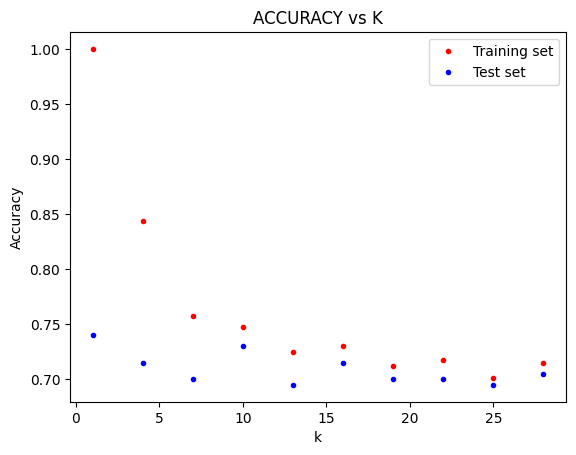

In [ ]:
#PUNTO 4
from sklearn import neighbors, datasets

#Ridefinisco 80-20 training e test set
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, train_size = 0.8)

#Liste per train e test values
train_score = []
test_score = []
#Best parameters
best_acc = 0.
best_k = 0

n_neighbors = np.arange(1, 30, 3) #questo è il k
print("k \t accuracy train \t accuracy test")
for i in range(len(n_neighbors)):
  clf = neighbors.KNeighborsClassifier(n_neighbors[i])
  clf.fit(x_train, y_train)
  train_score.append(clf.score(x_train, y_train))
  test_score.append(clf.score(x_test, y_test))
  print("{} \t\t {} \t\t {}".format(n_neighbors[i], train_score[i], test_score[i]))

  #Aggiorno best parameters (stavolta su test set direttamente)
  if (test_score[i] >= best_score):
    best_score = test_score[i]
    best_k = n_neighbors[i]

print()
print("Best accuracy on test set: {} \t Ottenuto con k: {}".format(best_score, best_k))

score_train = np.array(train_score)
score_test = np.array(test_score)

#Plot accuracy vs k for training set and test set
import matplotlib.pyplot as plt
plt.figure()
plt.title("ACCURACY vs K")
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.plot(n_neighbors, score_train, '.', label = 'Training set', color = 'r')
plt.plot(n_neighbors, score_test, '.', label = 'Test set', color = 'blue')
plt.legend()